In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Paths to your image and mask datasets
image_dir = "/content/drive/MyDrive/archive/Dataset/Dataset/X_test"
mask_dir = "/content/drive/MyDrive/archive/Mask/Mask/Y_test_Cancer"

# Get the list of all image and mask files
images = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')])
masks = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.png')])

image_subset = images[:1000]
mask_subset = masks[:1000]

# Train-validation split (80% train, 20% validation)
train_images, val_images, train_masks, val_masks = train_test_split(
    image_subset, mask_subset, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")


Training set size: 800
Validation set size: 200


In [ ]:
import tensorflow as tf

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Function to load and preprocess a single image or mask
def load_and_preprocess_image(file_path, is_mask=False):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1 if is_mask else 3)  # Grayscale for masks, RGB for images

    # Resize the image
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    # Normalize the pixel values
    img = img / 255.0

    return img

# Function to create a TensorFlow dataset
def create_dataset(image_paths, mask_paths, batch_size):
    # Create TensorFlow datasets for images and masks
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)

    # Preprocess images and masks
    image_dataset = image_dataset.map(lambda x: load_and_preprocess_image(x, is_mask=False), num_parallel_calls=AUTO)
    mask_dataset = mask_dataset.map(lambda x: load_and_preprocess_image(x, is_mask=True), num_parallel_calls=AUTO)

    # Combine image and mask datasets
    dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTO)

    return dataset

# Create datasets
train_dataset = create_dataset(train_images, train_masks, BATCH_SIZE)
val_dataset = create_dataset(val_images, val_masks, BATCH_SIZE)

# Verify the data pipeline
for images, masks in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")


Image batch shape: (32, 128, 128, 3)
Mask batch shape: (32, 128, 128, 1)


# Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3  # For RGB images
DROPOUT_RATE = 0.2
REGULARIZER = tf.keras.regularizers.l2(0.001)

# Function to create U-Net
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Dropout(DROPOUT_RATE)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Dropout(DROPOUT_RATE)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(p2)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Dropout(DROPOUT_RATE)(b1)
    b1 = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(b1)
    b1 = layers.BatchNormalization()(b1)

    # Decoder
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b1)
    u2 = layers.concatenate([u2, c2])
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(u2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Dropout(DROPOUT_RATE)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)

    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u3 = layers.concatenate([u3, c1])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(u3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(DROPOUT_RATE)(c4)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=REGULARIZER, padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_unet(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 64)     │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 128)    │              0 │ batch_normalization_4… │
├──────────────────────

 Total params: 469,089 (1.79 MB)

 Trainable params: 467,809 (1.78 MB)

 Non-trainable params: 1,280 (5.00 KB)

# Model Training

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 205ms/step - accuracy: 0.5099 - loss: 1.4029 - val_accuracy: 0.6741 - val_loss: 1.2322
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5181 - loss: 1.2828 - val_accuracy: 0.5759 - val_loss: 1.1784
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5419 - loss: 1.1994 - val_accuracy: 0.6565 - val_loss: 1.1254
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5737 - loss: 1.1356 - val_accuracy: 0.8135 - val_loss: 1.0763
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6148 - loss: 1.0811 - val_accuracy: 0.8600 - val_loss: 1.0293
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.6624 - loss: 1.0327 - val_accuracy: 0.8905 - val_loss: 0.9862
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7103 - loss: 0.9890 - val_accuracy: 0.9235 - val_loss: 0.9485
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.7567 - loss: 0.9487 - val_accuracy: 0.9447 -

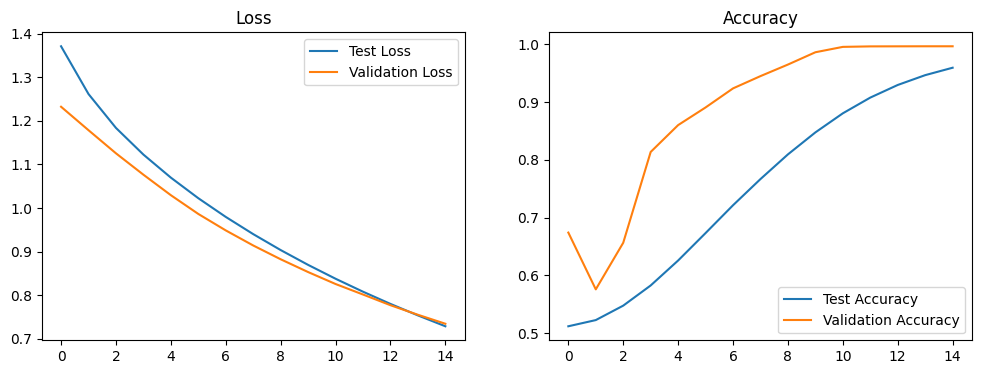

In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,  # Adjust based on your dataset and computational limits
    callbacks=early_stopping
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Test Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
